In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [20]:
!pip install medpy
!pip install torchio

In [21]:
import random
import torchio as tio
from torchio import AFFINE, DATA
import torchio
from torchio import ScalarImage, LabelMap, Subject, SubjectsDataset, Queue
from torchio.data import UniformSampler
from torchio.transforms import (
    RandomFlip,
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise,
    RandomMotion,
    RandomBiasField,
    RescaleIntensity,
    Resample,
    ToCanonical,
    ZNormalization,
    CropOrPad,
RandomSpike,
RandomBlur,
RandomSwap,
    HistogramStandardization,
    OneOf,
    Clamp,
    Compose,
    RandomGhosting,
)
from pathlib import Path
from glob import glob
from os.path import dirname, join, basename, isfile
import sys
from tqdm import tqdm
import os

In [22]:
# Use CIFAR-10 dataset for training and CIFAR-10-C dataset for testing
# Get CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]))

# Get CIFAR-10-C dataset which includes diffrent types of corruptions
#!wget https://zenodo.org/record/2535967/files/CIFAR-10-C.tar
#!tar -xvf CIFAR-10-C.tar

Files already downloaded and verified


In [23]:
class testDataset(Dataset):
    def __init__(self, data, label, transform=True, data_name = None):
        self.data = data
        self.label = label
        self.images_path = torch.tensor(np.load(os.path.join(data, data_name + ".npy")))
        self.images_class = torch.tensor(np.load(os.path.join(label,"labels.npy")))
        self.transform = transform
 
    def __len__(self):
        return self.images_path.shape[0] #return length
 
    def __getitem__(self, index):
        img = self.images_path[index, :, :]  # read every npy
        img = img[:,:,0] # drop the final dim
        label = self.images_class[index]  # read every npy
        img = np.expand_dims(img, axis=0)
        img = torch.Tensor(img)
        img = torch.cat([img, img, img], dim=0)
        label = label.type(torch.long)
        if self.transform is not None:
            img = self.transform(img)
        return img, label  # return data, label

In [24]:
# Define the transformer for the test dataset
val_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [25]:
# Split the dataset into training, validation
train_size = int(0.8 * len(train_dataset))
val_size = int(0.2 * len(train_dataset))

In [26]:
# Build the ResNet50 model with or without pretrained weights
# Change all Relu functions to LeakyRelu
def get_model(pretrain):
    if pretrain == 1:
        model = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
    else:
        model = torchvision.models.resnet50(weights=None)
    for name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            model._modules[name] = nn.LeakyReLU(inplace=True)
    model.classifier = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.LeakyReLU(inplace=True),
        nn.Linear(1024, 10),
    )
    return model

In [27]:
# Define the training function and return loss
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

# Define the validation function and return loss
def validate(model, device, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            valid_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return valid_loss

# Define the testing function and return accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), test_loss

In [28]:
# Define the optimizer
def get_optimizer(model, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    return optimizer

# Define the training process
def train_process(model, device, train_loader, valid_loader, optimizer, epochs):
    train_losses = []
    valid_losses = []
    for epoch in range(1, epochs + 1):
        train_losses.append(train(model, device, train_loader, optimizer, epoch))
        valid_losses.append(validate(model, device, valid_loader))
    return train_losses, valid_losses

# Define the testing process
def test_process(model, device, test_loader):
    test_acc = test(model, device, test_loader)
    return test_acc

In [29]:
# Define the device
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

mps


In [30]:
# Set the batch size used for model training
batch_size = 16
# Define the names for data
data_names = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

In [31]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Train Epoch: 1 [0/40000 (0%)]	Loss: 9.746256
Train Epoch: 1 [1600/40000 (4%)]	Loss: 1.385909


KeyboardInterrupt: 

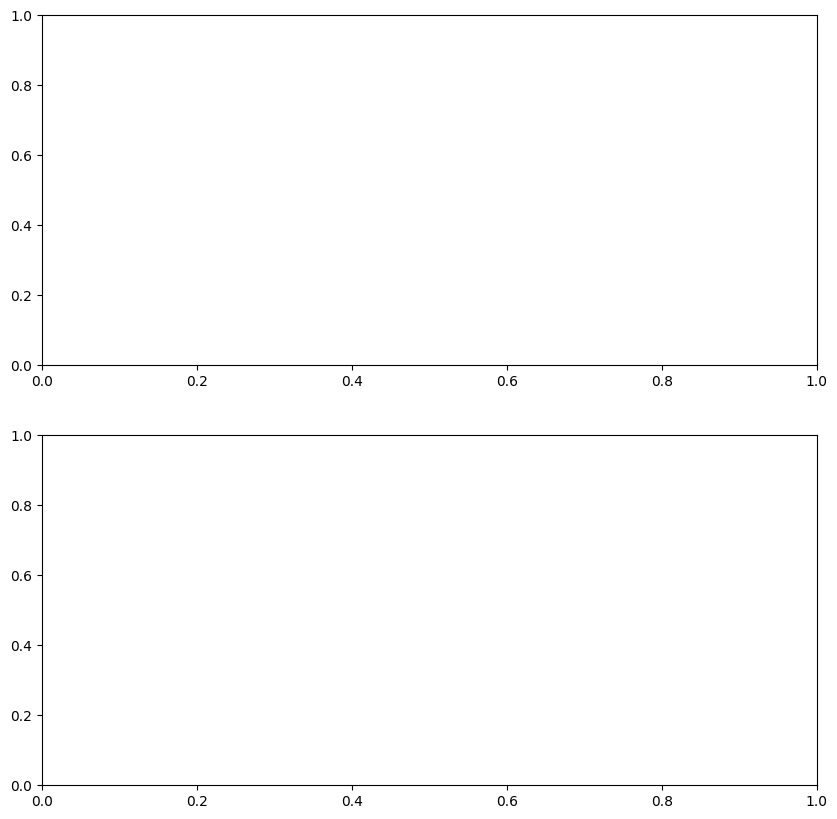

In [32]:
# Empty the GPU memory
torch.cuda.empty_cache()

# Start training and testing with batchsize = 16 and learning rate = 0.001 and leaky_relu
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
learnR = 0.001
test_accs = []
i = 0
model = get_model(1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
model = model.to(device)
optimizer = get_optimizer(model, learnR)
train_losses, valid_losses = train_process(model, device, train_loader, val_loader, optimizer, 60)

# Plot the training loss given batch size = 16 and learning rate = 0.001 and leaky_relu
axs[0].plot(train_losses)
axs[0].set_title('Training loss, given batch_size=16, learning_rate=0.001, leaky_relu')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Plot the validation loss given batch size = 16 and learning rate = 0.001 and leaky_relu
axs[1].plot(valid_losses)
axs[1].set_title('Validation loss, given batch_size=16, learning_rate=0.001, leaky_relu')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

# Change the train_losses, valid_losses, test_losses, test_accs as different pandas dataframes
train_lossespd = pd.DataFrame(train_losses)
valid_lossespd = pd.DataFrame(valid_losses)

# Save the dataframes as csv files
train_lossespd.to_csv('train_losses.csv')
valid_lossespd.to_csv('valid_losses.csv')

In [ ]:
# test accuracy and losses for different test data
test_accs = []
test_losses = []
for data_name in data_names:
    dataset = testDataset(data="./CIFAR-10-C", label="./CIFAR-10-C", transform=val_transformer, data_name= data_name)
    # Get the last 10000 images as test data
    lenth_of_dataset = len(dataset)
    test_dataset = torch.utils.data.Subset(dataset, range(lenth_of_dataset - 10000, lenth_of_dataset))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    test_acc, test_loss = test_process(model, device, test_loader)
    test_accs.append(test_acc)
    test_losses.append(test_loss)

# Plot the test accuracy for different test data
plt.figure(figsize=(10, 10))
plt.bar(data_names, test_accs)
plt.title('Test accuracy for different test data')
plt.xlabel('Test data')
plt.ylabel('Test accuracy')
plt.xticks(rotation=90)
plt.show()

# Plot the test loss for different test data
plt.figure(figsize=(10, 10))
plt.bar(data_names, test_losses)
plt.title('Test loss for different test data')
plt.xlabel('Test data')
plt.ylabel('Test loss')
plt.xticks(rotation=90)
plt.show()


# Change the results as a pandas dataframe
test_accspd = pd.DataFrame(test_accs, index=data_names)
test_lossspd = pd.DataFrame(test_losses, index=data_names)

# Save the dataframe as a csv file
test_accspd.to_csv('test_accs.csv')
test_lossspd.to_csv('test_losses.csv')